## Import Library:

In [1]:
!git clone https://github.com/rajeevratan84/image-segmentation-keras.git

fatal: destination path 'image-segmentation-keras' already exists and is not an empty directory.


In [2]:
%cd image-segmentation-keras
# !python setup.py install

/kaggle/working/image-segmentation-keras


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from keras.callbacks import ModelCheckpoint
from IPython.display import Image
import tensorflow as tf
from tensorflow.keras import backend as K
from keras_segmentation.models.segnet import segnet, vgg_segnet, resnet50_segnet, mobilenet_segnet
from tensorflow.keras.optimizers import Adam
import time

2024-07-31 19:23:01.656892: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 19:23:01.656946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 19:23:01.658420: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
image_train_list = os.listdir('/kaggle/input/cityscapes-dataset/images_prepped_train_cleaned/images_prepped_train_cleaned')
anns_train_list = os.listdir('/kaggle/input/cityscapes-dataset/annotations_prepped_train/annotations_prepped_train')
image_val_list = os.listdir('/kaggle/input/cityscapes-dataset/images_prepped_test/images_prepped_test')
anns_val_list = os.listdir('/kaggle/input/cityscapes-dataset/annotations_prepped_test/annotations_prepped_test')

print('number of train data pairs: ', len(set(image_train_list).intersection(anns_train_list)))
print('number of validation data pairs: ', len(set(image_val_list).intersection(anns_val_list)))
del image_train_list, anns_train_list, image_val_list, anns_val_list

number of train data pairs:  367
number of validation data pairs:  101


In [5]:
def dice_loss(y_true, y_pred, smooth = 1e-6):
    """
    Calculate Dice Loss between the ground truth and predictions.

    Parameters:
    - y_true: Ground truth labels (shape: [batch_size, height, width, num_classes])
    - y_pred: Predicted labels (shape: [batch_size, height, width, num_classes])
    - smooth: Smoothing factor to avoid division by zero

    Returns:
    - Dice Loss value
    """
    # Flatten the Tensors:
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(y_pred)

    # Calculate Intersection and Union:
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)

    # Compute Dice Coefficient:
    dice = (2. * intersection + smooth) / (union + smooth)

    # Return Dice Loss:
    return 1 - dice

In [6]:
model = segnet(n_classes = 30, input_height = 352, input_width = 480)

In [7]:
def custom_augmentation():
    return iaa.Sequential(
        [
            # apply the following augmenters to most images
#             iaa.GaussianBlur(sigma=(0.0, 0.5)),
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.GammaContrast((0.5, 2.0)),
            iaa.convolutional.Sharpen(alpha = (0.0, 0.2), lightness = (0.8, 1.2)),
#             iaa.Grayscale(alpha=(0.0, 1.0)),
#             iaa.pillike.FilterFindEdges(),
#             iaa.ShearX((-20, 20)),
#             iaa.AdditiveGaussianNoise(scale=(0, 0.1*255)),
#             iaa.Canny(alpha=(0.0, 0.5),colorizer=iaa.RandomColorsBinaryImageColorizer(color_true=255,color_false=0)),
        ])
# [sharpness, contrast], blur (jgn terlalu blur), saturation, hue

def image_preprocessing(image):
    image = tf.cast(image, tf.float32)
    scaled_image = image.numpy() / 255.0
    return scaled_image

In [8]:
from keras_segmentation.data_utils.data_loader import image_segmentation_generator, verify_segmentation_dataset
train_gen = image_segmentation_generator(images_path = "/kaggle/input/cityscapes-dataset/images_prepped_train_cleaned/images_prepped_train_cleaned/", 
                                         segs_path = "/kaggle/input/cityscapes-dataset/annotations_prepped_train/annotations_prepped_train/",  
                                         batch_size = 2,  
                                         n_classes = 30,
                                         input_height = 352, 
                                         input_width = 480, 
                                         output_height = model.output_height, 
                                         output_width = model.output_width,
                                         do_augment = False, 
#                                          augmentation_name=augmentation_name,
#                                          custom_augmentation=custom_augmentation, 
#                                          other_inputs_paths=other_inputs_paths,
#                                          preprocessing=image_preprocessing, 
                                         read_image_type = 1)

val_gen = image_segmentation_generator(images_path = "/kaggle/input/cityscapes-dataset/images_prepped_test/images_prepped_test/", 
                                       segs_path = "/kaggle/input/cityscapes-dataset/annotations_prepped_test/annotations_prepped_test/",  
                                       batch_size = 2,
                                       n_classes = 30, 
                                       input_height = 352, 
                                       input_width = 480, 
                                       output_height = model.output_height, 
                                       output_width = model.output_width,
                                       do_augment = False,
#                                          augmentation_name=augmentation_name,
#                                          custom_augmentation=custom_augmentation, 
#                                          other_inputs_paths=other_inputs_paths,
#                                          preprocessing=image_preprocessing, 
                                       read_image_type = 1)

In [9]:
verify_segmentation_dataset(images_path = "/kaggle/input/cityscapes-dataset/images_prepped_train_cleaned/images_prepped_train_cleaned/",
                            segs_path = "/kaggle/input/cityscapes-dataset/annotations_prepped_train/annotations_prepped_train/",
                            n_classes = 30)
verify_segmentation_dataset(images_path = "/kaggle/input/cityscapes-dataset/images_prepped_test/images_prepped_test/",
                            segs_path = "/kaggle/input/cityscapes-dataset/annotations_prepped_test/annotations_prepped_test/",
                            n_classes = 30)

100%|██████████| 367/367 [00:03<00:00, 119.10it/s]


Dataset verified! 


100%|██████████| 101/101 [00:00<00:00, 114.21it/s]

Dataset verified! 


True

In [10]:
checkpoint_path = "/kaggle/working/weights/vanillacnn_segnet.weights.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok = True)
checkpoint = ModelCheckpoint(checkpoint_path, 
                             monitor = "val_dice_loss",
                             save_best_only = True,
                             save_weights_only = True,
                             mode = "min")

In [11]:
model.compile(
    optimizer = Adam(learning_rate = 1e-4),
    loss = 'categorical_crossentropy', # dice_loss,
    metrics = [dice_loss, 'accuracy'] #, tf.keras.metrics.F1Score(average = "weighted")] # f1-score, accuracy
)

start_time = time.time()
model.fit(train_gen,
          steps_per_epoch = 512,
          validation_data = val_gen,
          validation_steps = 512,
          epochs = 10, 
          callbacks = [checkpoint],
          initial_epoch = 0)
print('Training completed in {} s'.format(time.time() - start_time))

Epoch 1/10
  2/512 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - accuracy: 0.0749 - dice_loss: 0.9598 - loss: 4.0941   

I0000 00:00:1722453819.418532     280 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


512/512 ━━━━━━━━━━━━━━━━━━━━ 95s 127ms/step - accuracy: 0.7239 - dice_loss: 0.4122 - loss: 1.0868 - val_accuracy: 0.6840 - val_dice_loss: 0.3684 - val_loss: 1.2061
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 63s 122ms/step - accuracy: 0.8266 - dice_loss: 0.2523 - loss: 0.5743 - val_accuracy: 0.8066 - val_dice_loss: 0.2777 - val_loss: 0.6276
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 61s 120ms/step - accuracy: 0.8536 - dice_loss: 0.2138 - loss: 0.4710 - val_accuracy: 0.7388 - val_dice_loss: 0.2987 - val_loss: 1.0312
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 62s 121ms/step - accuracy: 0.8681 - dice_loss: 0.1916 - loss: 0.4173 - val_accuracy: 0.8165 - val_dice_loss: 0.2371 - val_loss: 0.5618
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 62s 122ms/step - accuracy: 0.8844 - dice_loss: 0.1706 - loss: 0.3635 - val_accuracy: 0.8680 - val_dice_loss: 0.1716 - val_loss: 0.4888
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 62s 121ms/step - accuracy: 0.8970 - dice_loss: 0.1520 - loss: 0.3204 - val_accuracy: 0.8562 - va

In [12]:
print(model.history.history.keys())

dict_keys(['accuracy', 'dice_loss', 'loss', 'val_accuracy', 'val_dice_loss', 'val_loss'])


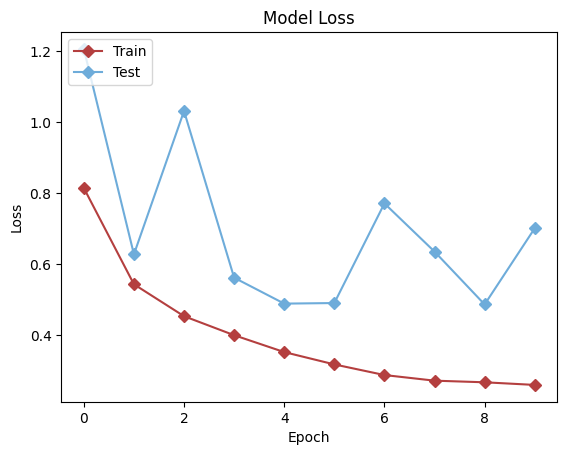

In [13]:
# Data:
epochs = range(len(model.history.history['loss']))
train_loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

# Plot training loss
plt.plot(epochs, train_loss, color = '#B43F3F', marker = 'D', label = 'Train')

# Plot validation loss
plt.plot(epochs, val_loss, color = '#6EACDA', marker = 'D', label = 'Test')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper left')
plt.show()

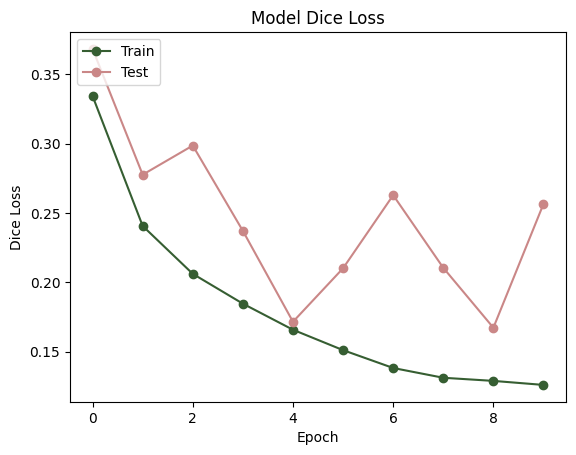

In [14]:
epochs = range(len(model.history.history['dice_loss']))
train_dice_loss = model.history.history['dice_loss']
val_dice_loss = model.history.history['val_dice_loss']

# Plot training dice loss:
plt.plot(epochs, train_dice_loss, color = '#365E32', marker = 'o', label = 'Train')

# Plot validation dice loss:
plt.plot(epochs, val_dice_loss, color = '#CA8787', marker = 'o', label = 'Test')

plt.title('Model Dice Loss')
plt.ylabel('Dice Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'upper left')
plt.show()

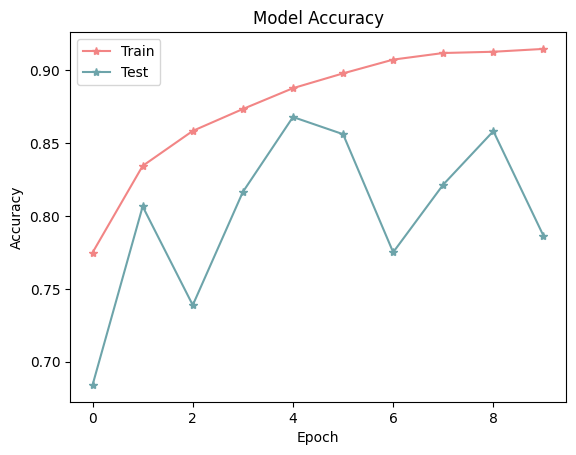

In [15]:
epochs = range(len(model.history.history['accuracy']))
train_accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

# Plot training accuracy
plt.plot(epochs, train_accuracy, color = '#F28585', marker = '*', label = 'Train')

# Plot validation accuracy
plt.plot(epochs, val_accuracy, color = '#6DA4AA', marker = '*', label = 'Test')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 'upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


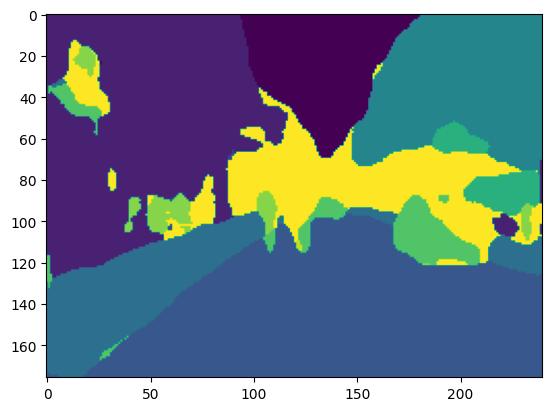

In [16]:
out = model.predict_segmentation(
    inp = "/kaggle/input/cityscapes-dataset/images_prepped_test/images_prepped_test/0016E5_07959.png"
)
plt.imshow(out);

In [17]:
from IPython.display import Image

o = model.predict_segmentation(
    inp = "/kaggle/input/cityscapes-dataset/images_prepped_test/images_prepped_test/0016E5_07959.png",
    out_fname = "/kaggle/working/out.png",
    overlay_img = True,
    show_legends = True,
    class_names = ["Sky","Building","Pole","Road","pavement","Tree","SignSymbol","Fence","Car","Pedestrian","Bicylist"]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


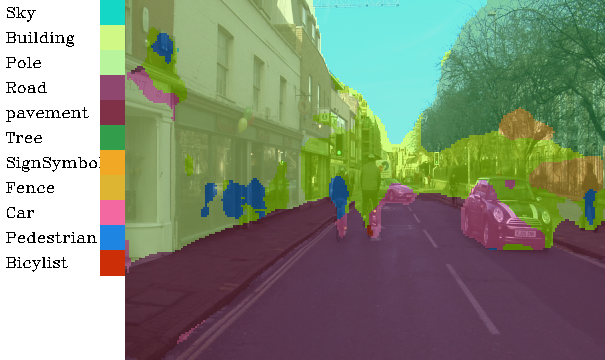

In [18]:
Image("/kaggle/working/out.png")